C:\Users\diede\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting price prediction model...
Preparing data for modeling...
Encoding categorical features...
Scaling features...
Training LightGBM models...
Training Random Forest model...
Training XGBoost models...
Training CatBoost models...

=== Model Evaluation ===
Mean Absolute Error: €69196.97
Root Mean Squared Error: €101810.39
R² Score: 0.6695
Winkler Score (alpha=0.2): 324903.1910
Creating shapley plot


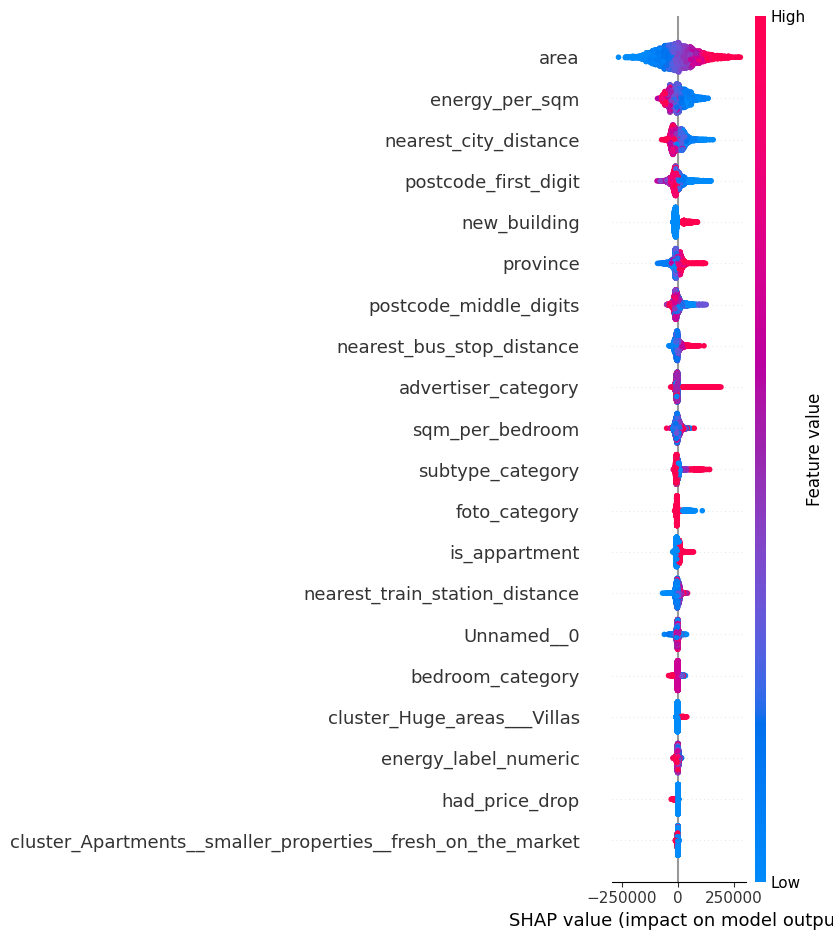


Generating visualization...


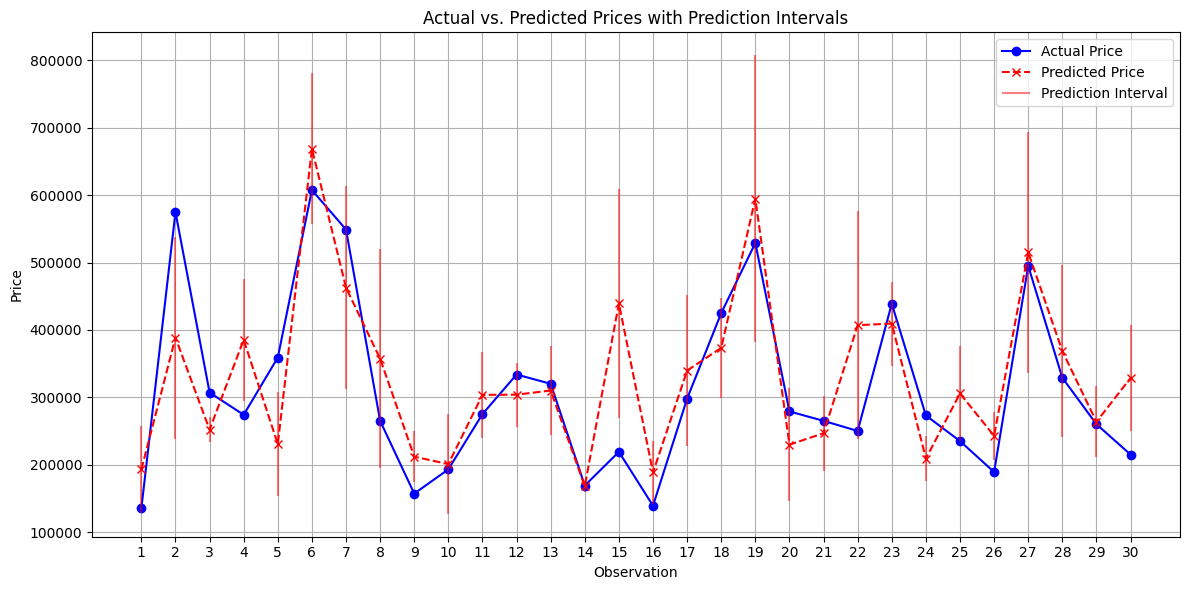

Process completed successfully!


In [ ]:
#Model with distance features
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import shap

warnings.filterwarnings("ignore")

# Calculate Winkler score for prediction intervals
def winkler_score(y_true, y_lower, y_upper, alpha=0.2):
    alpha = float(alpha)
    lower_clip = np.maximum(0, (y_lower - y_true))
    upper_clip = np.maximum(0, (y_true - y_upper))
    interval_length = (y_upper - y_lower)
    winkler_score = interval_length + (2/alpha) * (lower_clip + upper_clip)
    return np.mean(winkler_score)

def train_lightgbm(X_train, y_train, X_test, is_quantile=False, quantile_alpha=None):
    params = {
        'objective': 'regression' if not is_quantile else 'quantile',
        'metric': 'mae' if not is_quantile else 'quantile',
        'alpha': quantile_alpha if is_quantile else None,
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'num_leaves': 31,
        'max_depth': -1,
        'min_data_in_leaf': 20,
        'verbose': -1,
        'random_state': 42
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
    )
    return model, model.predict(X_test)

def train_random_forest(X_train, y_train, X_test):
    rf_model = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=2,
                                    max_features='log2', max_depth=20, random_state=39, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    return rf_model, rf_model.predict(X_test)

def train_xgboost(X_train, y_train, X_test, y_test, is_quantile=False, quantile_alpha=None):
    fixed_params = {
        'objective': 'reg:quantileerror' if is_quantile else 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42
    }
    if is_quantile:
        fixed_params['quantile_alpha'] = quantile_alpha

    params = {**fixed_params, **{'max_depth': 6, 'learning_rate': 0.1, 'n_estimators': 200,
                'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 1.0}}
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    return model, model.predict(X_test)

def train_catboost(X_train, y_train, X_test, y_test, cat_features, is_quantile=False, quantile_alpha=None):
    params = {
        'loss_function': f'Quantile:alpha={quantile_alpha}' if is_quantile else 'MAE',
        'eval_metric': 'Quantile' if is_quantile else 'MAE',
        'iterations': 500,
        'learning_rate': 0.1,
        'random_seed': 42,
        'verbose': 0,
        'cat_features': cat_features
    }

    model = CatBoostRegressor(**params)
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)
    model.fit(train_pool, eval_set=test_pool)
    return model, model.predict(X_test)


def build_base_models(X_train_scaled, X_train_unscaled, y_train, X_test_scaled, X_test_unscaled, y_test, alpha, cat_features):
    # --- LightGBM Model ---
    print("Training LightGBM models...")
    lightgbm_model, y_pred_lgb = train_lightgbm(X_train_scaled, y_train, X_test_scaled)
    _, y_lower_lgb = train_lightgbm(X_train_scaled, y_train, X_test_scaled, is_quantile=True, quantile_alpha=alpha/2)
    _, y_upper_lgb = train_lightgbm(X_train_scaled, y_train, X_test_scaled, is_quantile=True, quantile_alpha=1-alpha/2)

    # --- Random Forest Model ---
    print("Training Random Forest model...")
    rf_model, y_pred_rf = train_random_forest(X_train_scaled, y_train, X_test_scaled)

    # --- XGBoost Model ---
    print("Training XGBoost models...")
    xgboost_model, y_pred_xgb = train_xgboost(X_train_scaled, y_train, X_test_scaled, y_test)
    _, y_lower_xgb = train_xgboost(X_train_scaled, y_train, X_test_scaled, y_test, is_quantile=True, quantile_alpha=alpha/2)
    _, y_upper_xgb = train_xgboost(X_train_scaled, y_train, X_test_scaled, y_test, is_quantile=True, quantile_alpha=1-alpha/2)

    # --- CatBoost Model ---
    print("Training CatBoost models...")
    catboost_model, y_pred_cat = train_catboost(X_train_unscaled, y_train, X_test_unscaled, y_test, cat_features)
    _, y_lower_cat = train_catboost(X_train_unscaled, y_train, X_test_unscaled, y_test, cat_features, is_quantile=True, quantile_alpha=alpha/2)
    _, y_upper_cat = train_catboost(X_train_unscaled, y_train, X_test_unscaled, y_test, cat_features, is_quantile=True, quantile_alpha=1-alpha/2)

    return (lightgbm_model, rf_model, xgboost_model, catboost_model), (y_pred_lgb, y_lower_lgb, y_upper_lgb, y_pred_rf, y_pred_xgb, y_lower_xgb, y_upper_xgb, y_pred_cat, y_lower_cat, y_upper_cat)


def build_models(train_df, test_df, target='price', alpha=0.2):
    print("Preparing data for modeling...")
    # Data Preparation
    X_train = train_df.drop(['id', target], axis=1, errors='ignore')
    y_train = train_df[target]
    X_test = test_df.drop(['id', target], axis=1, errors='ignore')
    y_test = test_df[target]

    # Combine data for consistent processing
    combined_df = pd.concat([X_train, X_test], axis=0)
    cat_columns = combined_df.select_dtypes(include=['object', 'category']).columns

    # Label encoding for categorical features
    print("Encoding categorical features...")
    label_encoders = {}
    for col in cat_columns:
        le = LabelEncoder()
        combined_df[col] = le.fit_transform(combined_df[col].astype(str))
        label_encoders[col] = le

    # Split back to train and test
    X_train = combined_df.iloc[:len(X_train), :]
    X_test = combined_df.iloc[len(X_train):, :]

    # Keep unscaled copies for CatBoost
    X_train_unscaled = X_train.copy()
    X_test_unscaled = X_test.copy()
    cat_features_indices = [X_train.columns.get_loc(col) for col in cat_columns]

    # Fill missing values
    combined_df = combined_df.fillna(combined_df.median())
    X_train = combined_df.iloc[:len(X_train), :]
    X_test = combined_df.iloc[len(X_train):, :]

    # Scale features
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame with cleaned column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    # Clean column names for compatibility
    def clean_column_names(df):
        df.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
        return df

    X_train_scaled = clean_column_names(X_train_scaled)
    X_test_scaled = clean_column_names(X_test_scaled)
    X_train_unscaled = clean_column_names(X_train_unscaled)
    X_test_unscaled = clean_column_names(X_test_unscaled)

    #Equal weights for all models for making weighted adjustments to the prediction intervals
    best_weights = {'lgb': 0.25, 'rf': 0.25, 'xgb': 0.25, 'cat': 0.25}
    best_k = 1e-05 #k-value that determines how heavy the prediction intervals are scaled

    # Build final models with best weights
    base_models, base_preds = build_base_models(X_train_scaled, X_train_unscaled, y_train,
                                               X_test_scaled, X_test_unscaled, y_test,
                                               alpha, cat_features_indices)
    lightgbm_model, rf_model, xgboost_model, catboost_model = base_models
    y_pred_lgb, y_lower_lgb, y_upper_lgb, y_pred_rf, y_pred_xgb, y_lower_xgb, y_upper_xgb, y_pred_cat, y_lower_cat, y_upper_cat = base_preds


    y_pred_combined = (
        best_weights['lgb'] * y_pred_lgb +
        best_weights['rf'] * y_pred_rf +
        best_weights['xgb'] * y_pred_xgb +
        best_weights['cat'] * y_pred_cat
    )

    # Weighted combination of *differences*
    diff_rf = np.abs(y_pred_combined - y_pred_rf)
    diff_lgb = np.abs(y_pred_combined - y_pred_lgb)
    diff_cat = np.abs(y_pred_combined - y_pred_cat)
    diff_xgb = np.abs(y_pred_combined - y_pred_xgb)

    combined_diff = (
        best_weights['rf'] * diff_rf +
        best_weights['lgb'] * diff_lgb +
        best_weights['cat'] * diff_cat +
        best_weights['xgb'] * diff_xgb
    )

    # Combine upper and lower quantiles
    y_lower_combined = (
        best_weights['lgb'] * y_lower_lgb +
        best_weights['rf'] * y_lower_lgb +
        best_weights['xgb'] * y_lower_xgb +
        best_weights['cat'] * y_lower_cat
    )

    y_upper_combined = (
        best_weights['lgb'] * y_upper_lgb +
        best_weights['rf'] * y_upper_lgb +
        best_weights['xgb'] * y_upper_xgb +
        best_weights['cat'] * y_upper_cat
    )

    avg_prediction = np.mean(np.abs(y_pred_combined))
    scaled_diff = combined_diff / (avg_prediction + 1e-8)
    scaling_factor = np.exp(-best_k * scaled_diff)

    # Create final prediction intervals
    initial_interval_width = y_upper_combined - y_lower_combined
    adjusted_interval_width = initial_interval_width * scaling_factor
    y_pred_final = y_pred_combined
    y_lower_final = np.maximum(0, y_pred_final - adjusted_interval_width / 2)
    y_upper_final = np.maximum(0, y_pred_final + adjusted_interval_width / 2)

    # Evaluate model performance (using the tuned weights and k)
    print("\n=== Model Evaluation ===")
    mae = mean_absolute_error(y_test, y_pred_final)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
    r2 = r2_score(y_test, y_pred_final)
    w_score = winkler_score(y_test, y_lower_final, y_upper_final, alpha=alpha)
    print(f"Mean Absolute Error: €{mae:.2f}")
    print(f"Root Mean Squared Error: €{rmse:.2f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Winkler Score (alpha={alpha}): {w_score:.4f}")

    # Save predictions to test dataframe
    test_df['predicted_price'] = y_pred_final
    test_df['lower_bound'] = y_lower_final
    test_df['upper_bound'] = y_upper_final
    
    #Shapley plot
    print("Creating shapley plot")    
    # Choose a model for Shapley value calculation (e.g., XGBoost)
    explainer = shap.Explainer(xgboost_model)
    shap_values = explainer(X_test_scaled)

    # Summary plot
    shap.summary_plot(shap_values, X_test_scaled)

    return base_models, (y_pred_final, y_lower_final, y_upper_final), y_test


def visualize_results(y_test, y_pred_final, y_lower_final, y_upper_final, num_observations=30):
    print("\nGenerating visualization...")
    # Select random observations
    num_observations = min(num_observations, len(y_test))  # Ensure we don't exceed the length of y_test
    indices = np.arange(num_observations) # Use a simple index range


    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_observations + 1), y_test.iloc[indices], marker='o', linestyle='-', color='blue', label='Actual Price')
    plt.plot(range(1, num_observations + 1), y_pred_final[indices], marker='x', linestyle='--', color='red', label='Predicted Price')
    plt.vlines(range(1, num_observations + 1), y_lower_final[indices], y_upper_final[indices], color='red', alpha=0.5, label='Prediction Interval')

    plt.xlabel('Observation')
    plt.ylabel('Price')
    plt.title('Actual vs. Predicted Prices with Prediction Intervals')
    plt.xticks(range(1, num_observations + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Starting price prediction model...")
    train_df = pd.read_csv("C:/Users/diede/Downloads/train_data_0322.csv")
    test_df = pd.read_csv("C:/Users/diede/Downloads/test_data_0322.csv")
    alpha_value = 0.2

    # Build and evaluate models
    base_models, final_predictions, y_test = build_models(train_df, test_df, alpha=alpha_value)
    y_pred_final, y_lower_final, y_upper_final = final_predictions

    # Visualize results
    visualize_results(y_test, y_pred_final, y_lower_final, y_upper_final)

    print("Process completed successfully!")